In [3]:
import pandas as pd
import seaborn as sn
import re,random,pickle,warnings
import numpy as np
from keras.preprocessing.text import Tokenizer 
from nltk.corpus import stopwords  
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve, auc,precision_recall_curve,f1_score
from sklearn.feature_extraction import text 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout,Bidirectional
from keras.utils import pad_sequences


### Load Data

In [4]:
df = pd.read_csv("C:\\Users\\LENOVO\\jupyternote\\Deep Learning\\tweet.csv")
df.head(5)

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42610 entries, 0 to 42609
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       41328 non-null  object
 1   sentiment  41329 non-null  object
dtypes: object(2)
memory usage: 665.9+ KB


### Handling Missing Data

In [6]:
df.dropna(subset=['text'], inplace=True)
df.dropna(subset=['sentiment'], inplace=True)

def func(sentiment):
    if sentiment =='positive' or sentiment == 1:
        return 1;
    elif sentiment =='negative' or sentiment == 0:
        return 0;
    elif sentiment == 'neutral':
        return None

df['sentiment']=df['sentiment'].apply(lambda i: func(i))

df=df.sort_values('sentiment',ascending=False,ignore_index=True)
df

,text,sentiment
0,"Ooh, I love sweet potato fries! We should def...",1.0
1,Happy mothers day to all the mums!,1.0
2,awwww how cute its a pUG,1.0
3,I googled 'engagement rings' & this is the EX...,1.0
4,ok point taken. I`ll tell my team to stop ou...,1.0
...,...,...
41323,No Depression by G Herbo is my mood from now o...,NaN
41324,What do you do when depression succumbs the br...,NaN
41325,Ketamine Nasal Spray Shows Promise Against Dep...,NaN
41326,dont mistake a bad day with depression! everyo...,NaN


In [7]:
df.dropna(subset=['sentiment'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18467 entries, 0 to 18466
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   text       18467 non-null  object 
 1   sentiment  18467 non-null  float64
dtypes: float64(1), object(1)
memory usage: 432.8+ KB


In [8]:
print(df['sentiment'].value_counts())

sentiment
1.0    9685
0.0    8782
Name: count, dtype: int64


### Text Preprocessing

In [9]:
def func_1(text):
    stop_words=set(stopwords.words('english'))
    lemmatizer=WordNetLemmatizer()
    
    cleaned_string = re.sub(r'[-_.,;:\'"#<>\/=&@*!)(}{?\d]', '', text)
    cleaned_string = cleaned_string.lower()
    cleaned_string = re.sub('https://.*','',cleaned_string) 
    cleaned_string = re.sub(pattern='@[a-zA-Z_0-9]*', repl='@user',string=cleaned_string)
    cleaned_string = cleaned_string.lower()
    cleaned_string = ' '.join([i for i in cleaned_string.split() if i not in stop_words])

    lemmatized_words = [lemmatizer.lemmatize(word) for word in cleaned_string.split()]
    lemmatized_string = ' '.join(lemmatized_words)
    
    return lemmatized_string

In [10]:
df['text'][1]

'Happy mothers day to all the mums!'

In [11]:
df['text']=df['text'].apply(lambda i :func_1(i))
df['text'][1]

'happy mother day mum'

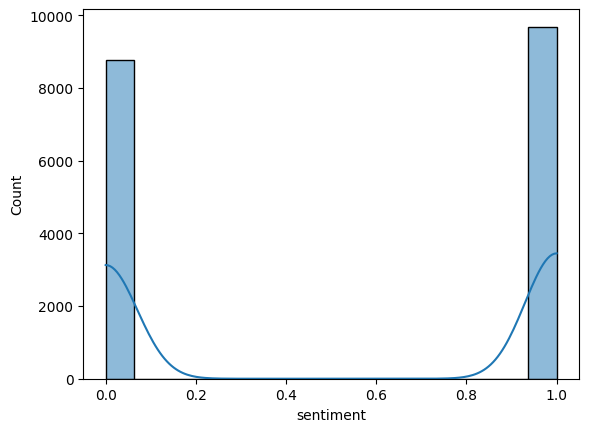

In [12]:
def plot():
    sn.histplot(df['sentiment'], kde=True)
plot()

### Spliting the Data

In [13]:
df_shuffled = shuffle(df)

warnings.filterwarnings("ignore")

x_train,x_test,y_train,y_test = train_test_split(df_shuffled.text, df_shuffled.sentiment, train_size=0.7,random_state=42)


### No of Features

In [14]:
count_vect=CountVectorizer()
feature_vector=count_vect.fit(df.text)

features=feature_vector.get_feature_names_out()

print('Total no of features',len(features))

Total no of features 19643


### Tokenization

In [15]:
tokens=10000
tokens=tokens
tokenizer=Tokenizer(num_words=tokens,oov_token="<OOV>")

tokenizer.fit_on_texts(x_train)
tokenizer.fit_on_texts(x_test)

In [16]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [17]:
x_test[0]

[889, 528, 3706, 137, 504, 47, 221, 47, 49, 75, 33, 17, 97]

### Vocabulory Size of Data

In [18]:
vocab_size=len(tokenizer.word_index)+1
print("Vocabulory size:",vocab_size)

Vocabulory size: 19654


### Average sentence size

In [19]:
avg=sum(len(sentence.split()) for sentence in df['text'])/len(df.text)
print(avg+1)

8.556939405425894


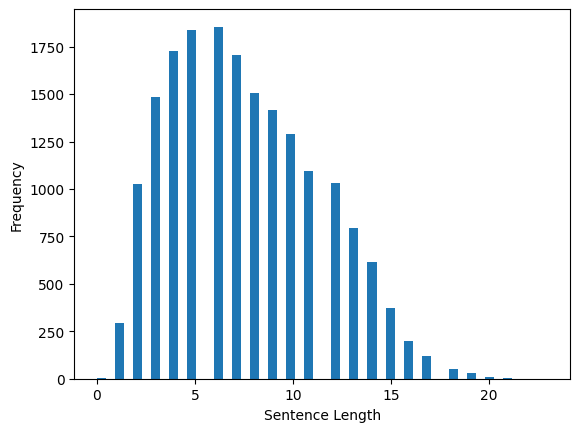

In [20]:
plt.hist([len(sentence.split()) for sentence in df['text']], bins=50)
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

### Padding Data

In [21]:
x_train = pad_sequences(x_train, padding='post', maxlen=25)  # Set maxlen to 35
x_test = pad_sequences(x_test, padding='post', maxlen=25)  

In [22]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

(12926, 25)
(5541, 25)
(12926,)


### Model building using LSTM and Training

In [23]:
lstm_model = Sequential()

lstm_model.add(Embedding(input_dim=vocab_size,output_dim=5,input_length=25))
lstm_model.add(Dropout(0.6))

lstm_model.add(LSTM(units=64,return_sequences=True))
lstm_model.add(Dropout(0.6))

lstm_model.add(LSTM(units=64,return_sequences=False))
lstm_model.add(Dropout(0.6))

lstm_model.add(Dense(40,activation='relu'))
lstm_model.add(Dropout(0.5))

lstm_model.add(Dense(units=1, activation='sigmoid'))

lstm_model.summary()

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 5)             98270     
                                                                 
 dropout (Dropout)           (None, 25, 5)             0         
                                                                 
 lstm (LSTM)                 (None, 25, 64)            17920     
                                                                 
 dropout_1 (Dropout)         (None, 25, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 40)                

In [24]:
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping

def scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch != 0:
        return lr * 0.8
    else:
        return lr

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_schedule = LearningRateScheduler(scheduler)


history_1 = lstm_model.fit(x_train,y_train,epochs=12,batch_size=64,validation_data=(x_test, y_test)
                       ,callbacks=[early_stopping,lr_schedule])

Epoch 1/12


202/202 [==============================] - 11s 33ms/step - loss: 0.6920 - accuracy: 0.5233 - val_loss: 0.6906 - val_accuracy: 0.5145 - lr: 0.0010
Epoch 2/12
202/202 [==============================] - 6s 29ms/step - loss: 0.4846 - accuracy: 0.7715 - val_loss: 0.3732 - val_accuracy: 0.8334 - lr: 0.0010
Epoch 3/12
202/202 [==============================] - 5s 27ms/step - loss: 0.3673 - accuracy: 0.8501 - val_loss: 0.3381 - val_accuracy: 0.8645 - lr: 0.0010
Epoch 4/12
202/202 [==============================] - 5s 27ms/step - loss: 0.3276 - accuracy: 0.8669 - val_loss: 0.3113 - val_accuracy: 0.8670 - lr: 0.0010
Epoch 5/12
202/202 [==============================] - 5s 27ms/step - loss: 0.2993 - accuracy: 0.8854 - val_loss: 0.3086 - val_accuracy: 0.8659 - lr: 0.0010
Epoch 6/12
202/202 [==============================] - 5s 26ms/step - loss: 0.2710 - accuracy: 0.8976 - val_loss: 0.3216 - val_accuracy: 0.8695 - lr: 8.0000e-04
Epoch 7/12
202/202 [==============================] - 5s 

### Model Accurancy

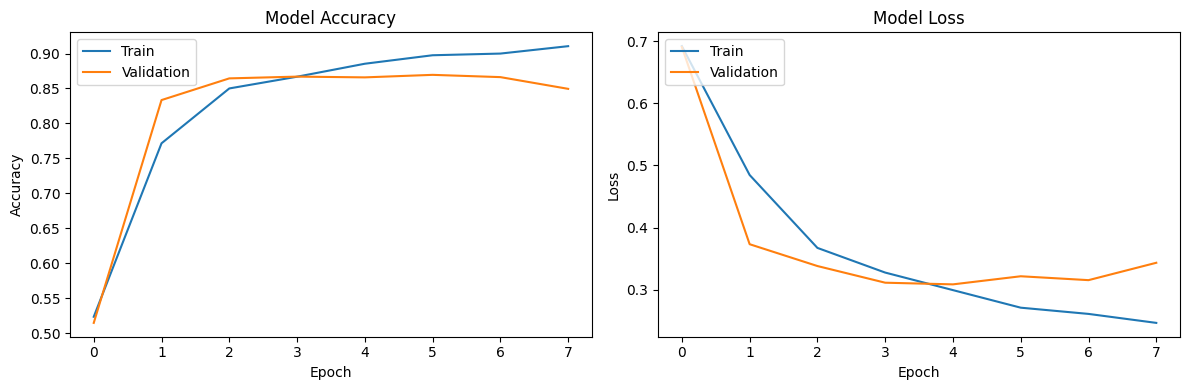

In [25]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [26]:
y_pred = lstm_model.predict(x_test)

174/174 [==============================] - 2s 7ms/step


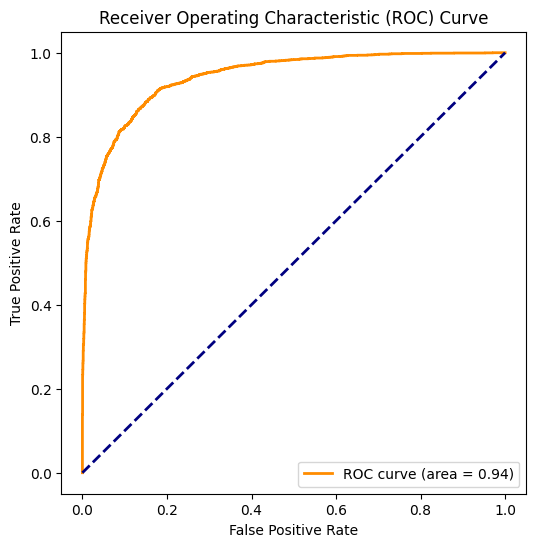

In [27]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

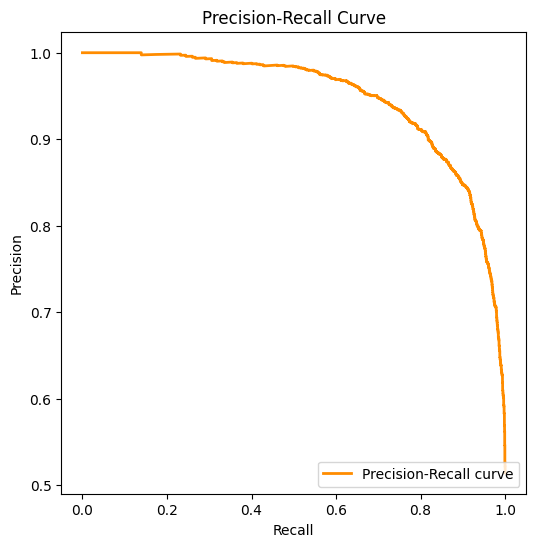

In [28]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Plot Precision-Recall curve
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.show()

### Threshold Value

In [29]:
f1_scores = [f1_score(y_test, (y_pred >= t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
print(best_threshold)

0.3508308


### Confusion Matrix

              precision    recall  f1-score   support

         0.0       0.90      0.82      0.86      2690
         1.0       0.84      0.91      0.88      2851

    accuracy                           0.87      5541
   macro avg       0.87      0.87      0.87      5541
weighted avg       0.87      0.87      0.87      5541



Text(8.222222222222223, 0.5, 'Truth')

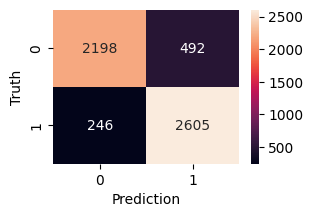

In [30]:
threshold = best_threshold
y_pred_labels = np.where(y_pred >= threshold, 1, 0)

print(classification_report(y_test, y_pred_labels))
cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize = (3,2))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

### Model Prediction

In [31]:
def predictions(model,text):
    new_text=func_1(text)
    new_text= tokenizer.texts_to_sequences([new_text])
    new_text= pad_sequences(new_text, padding='post', maxlen=25) 
    predictions = model.predict(new_text)
    if predictions > best_threshold:
        output='The review is positive'
        value=predictions
    else:
        output='The review is negative'
        value=predictions
    return output,value

In [32]:
text = "The movie was bad bad and worst, i will not recommend this movie to anyone"
predicted_value,value=predictions(lstm_model,text)

print(predicted_value,value)

1/1 [==============================] - 0s 26ms/step
The review is negative [[0.00570907]]


In [33]:
text = "The movie was moderate, i will not recommend this movie to anyone"

predicted_value,value=predictions(lstm_model,text)

print(predicted_value,value)

1/1 [==============================] - 0s 25ms/step
The review is negative [[0.23646702]]


In [34]:
text = "the free fillin` app on my ipod is fun, im addicted"

predicted_value,value=predictions(lstm_model,text)

print(predicted_value,value)


1/1 [==============================] - 0s 27ms/step
The review is positive [[0.8955157]]


## Model building using Bidirectional LSTM and Training

In [35]:
lstm_bi_model=Sequential()

lstm_bi_model.add(Embedding(input_dim=vocab_size,output_dim=5,input_length=25))
lstm_bi_model.add(Dropout(0.7))


lstm_bi_model.add(Bidirectional(LSTM(units=64,return_sequences=False)))
lstm_bi_model.add(Dropout(0.7))

lstm_bi_model.add(Dense(20,activation='relu'))
lstm_bi_model.add(Dropout(0.5))

lstm_bi_model.add(Dense(units=1, activation='sigmoid'))

lstm_bi_model.summary()

lstm_bi_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 25, 5)             98270     
                                                                 
 dropout_4 (Dropout)         (None, 25, 5)             0         
                                                                 
 bidirectional (Bidirection  (None, 128)               35840     
 al)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 20)                2580      
                                                                 
 dropout_6 (Dropout)         (None, 20)                0         
                                                      

In [36]:
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping

def scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch != 0:
        return lr * 0.8
    else:
        return lr

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_schedule = LearningRateScheduler(scheduler)


history_2 = lstm_bi_model.fit(x_train,y_train,epochs=15,batch_size=16,validation_data=(x_test, y_test)
                       ,callbacks=[early_stopping,lr_schedule])

Epoch 1/15
808/808 [==============================] - 13s 12ms/step - loss: 0.6060 - accuracy: 0.6478 - val_loss: 0.3835 - val_accuracy: 0.8477 - lr: 0.0010
Epoch 2/15
808/808 [==============================] - 9s 11ms/step - loss: 0.4427 - accuracy: 0.8067 - val_loss: 0.3349 - val_accuracy: 0.8549 - lr: 0.0010
Epoch 3/15
808/808 [==============================] - 9s 11ms/step - loss: 0.3875 - accuracy: 0.8350 - val_loss: 0.3220 - val_accuracy: 0.8623 - lr: 0.0010
Epoch 4/15
808/808 [==============================] - 9s 11ms/step - loss: 0.3567 - accuracy: 0.8546 - val_loss: 0.3215 - val_accuracy: 0.8601 - lr: 0.0010
Epoch 5/15
808/808 [==============================] - 9s 11ms/step - loss: 0.3438 - accuracy: 0.8618 - val_loss: 0.3142 - val_accuracy: 0.8634 - lr: 0.0010
Epoch 6/15
808/808 [==============================] - 9s 11ms/step - loss: 0.3129 - accuracy: 0.8748 - val_loss: 0.3069 - val_accuracy: 0.8668 - lr: 8.0000e-04
Epoch 7/15
808/808 [==============================] - 9s 11

### Model Accurancy

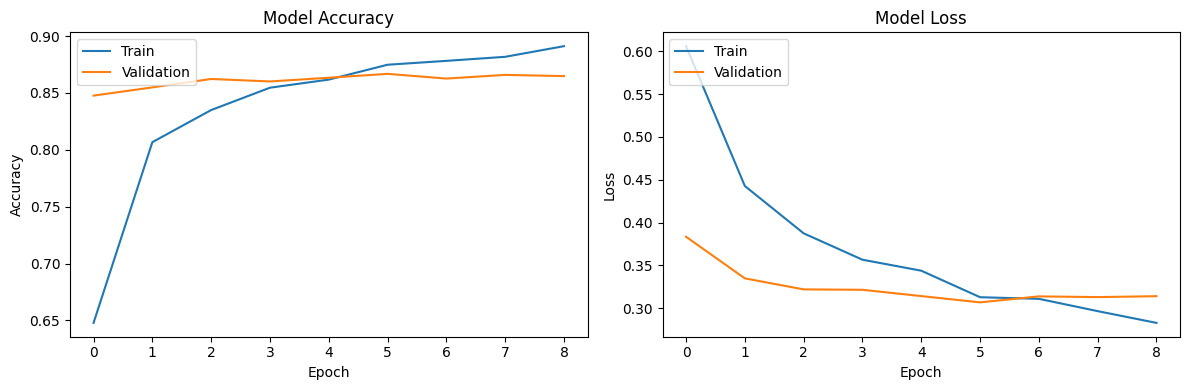

In [37]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

### Threshold Value

In [38]:
y_pred = lstm_bi_model.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

f1_scores = [f1_score(y_test, (y_pred >= t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
print(best_threshold)

174/174 [==============================] - 1s 5ms/step
0.42854056


### Model Prediction

In [39]:
def predictions(model,text):
    new_text=func_1(text)
    new_text= tokenizer.texts_to_sequences([new_text])
    new_text= pad_sequences(new_text, padding='post', maxlen=25) 
    predictions = model.predict(new_text)
    if predictions > best_threshold:
        output='The review is positive'
        value=predictions
    else:
        output='The review is negative'
        value=predictions
    return output,value

In [40]:
text = "the free fillin` app on my ipod is fun, im addicted"

predicted_value,value=predictions(lstm_bi_model,text)

print(predicted_value,value)


1/1 [==============================] - 0s 25ms/step
The review is positive [[0.8757312]]


In [41]:
text = "The movie was bad bad and worst, i will not recommend this movie to anyone"
predicted_value,value=predictions(lstm_bi_model,text)

print(predicted_value,value)

1/1 [==============================] - 0s 24ms/step
The review is negative [[0.00215785]]


In [42]:
text = "The movie was moderate, i will not recommend this movie to anyone"

predicted_value,value=predictions(lstm_bi_model,text)

print(predicted_value,value)

1/1 [==============================] - 0s 24ms/step
The review is positive [[0.43632603]]


### Saving Model

In [ ]:
recurrent.save('sentiment_rnn_tweet_20_37.h5')

In [ ]:
loaded_model=load_model('sentiment_rnn_tweet_10_37.h5')
loaded_model.summary()

In [ ]:
with open('tokenizer_lstm_tweet_20_37.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)